# Simulating Spurious Association
This is a simple simulation of spurious associations based on the book [Statistical Rethinking by Richard McElreath](https://xcelab.net/rm/statistical-rethinking/) chapter 5.1.

In [1]:
from scipy import stats
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import seaborn as sns
import pandas as pd
from causalgraphicalmodels import CausalGraphicalModel

The purpose of this simulation is to show that with a mutiple regression model it's possible to spot spurious associations.

Below `x_real` which is a truly causal predictor that influences both `y` and `x_spur`.

In [2]:
SAMP_SIZE = 10000 # size of sample

# all standardised -> mean=0, std=1
x_real = stats.norm.rvs(size=SAMP_SIZE)
x_spur = stats.norm.rvs(x_real)
y = stats.norm.rvs(x_real)

# creating a pandas dataframe
d = {'x_real': x_real,
    'x_spur': x_spur,
    'y': y}
df = pd.DataFrame(data=d)
df.head()

,x_real,x_spur,y
0,-1.970821,-1.575505,-2.838749
1,0.200543,0.822676,-0.897098
2,-0.928119,-1.071415,-1.482842
3,-0.973124,-1.805664,-0.945715
4,0.641437,2.294682,1.262307


In [3]:
df.describe()

,x_real,x_spur,y
count,10000.000000,10000.000000,10000.000000
mean,0.009982,0.010513,-0.008281
std,1.015856,1.421543,1.436777
min,-4.018051,-6.155125,-5.594109
25%,-0.660883,-0.937331,-0.972944
50%,-0.008714,-0.014614,-0.029641
75%,0.669977,0.952666,0.953371
max,3.657182,5.825424,5.808832


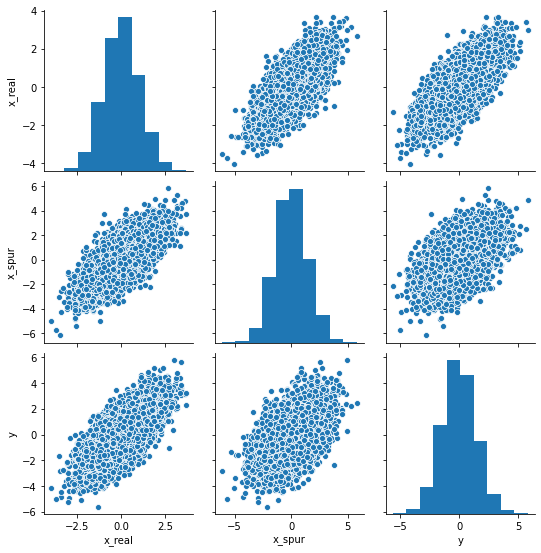

In [4]:
sns.pairplot(data=df)

We can notice by the pairplot above that `x_real` and `x_spur` seem be quite correlated to `y`.
<br>
<br>
The same can be seen on the correlation matrix bellow. However it's important to observe that the correlation between `x_spur` and `x_real` is quite high (as expected).

In [5]:
df.corr()

,x_real,x_spur,y
x_real,1.000000,0.710085,0.715271
x_spur,0.710085,1.000000,0.503881
y,0.715271,0.503881,1.000000


### Regressing with the spurious variable
Modeling for the spurious `x_spur` data we can see bellow it has a good correlation, of `0.5` and a tiny standard deviation of `0.1`, with `y`.

In [6]:
with pm.Model() as spur_t:
    a = pm.Normal('a', 0, 1)
    c = pm.Normal('c', 0, 1)
    mu = pm.Deterministic('mu', a + c*x_spur)
    sigma = pm.Exponential('sigma', 1)
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=df['y'])
    
    spur_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2803.06draws/s]
The acceptance probability does not match the target. It is 0.8813556835686138, but should be close to 0.8. Try to increase the number of tuning steps.


In [7]:
varnames = ['~mu']
az.summary(spur_trace, varnames, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,-0.01,0.01,-0.04,0.01
c,0.51,0.01,0.49,0.53
sigma,1.24,0.01,1.23,1.26


### Multivariate regression
However when we include the variable `x_real` we have a different result as shown bellow:

In [8]:
with pm.Model() as full_model:
    a = pm.Normal('a', 0, 1)
    b = pm.Normal('b', 0, 1)
    c = pm.Normal('c', 0, 1)
    mu = pm.Deterministic('mu', a + b*x_real + c*x_spur)
    sigma = pm.Exponential('sigma', 1)
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=df['y'])
    
    full_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1987.35draws/s]
The acceptance probability does not match the target. It is 0.8795302085692124, but should be close to 0.8. Try to increase the number of tuning steps.


/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

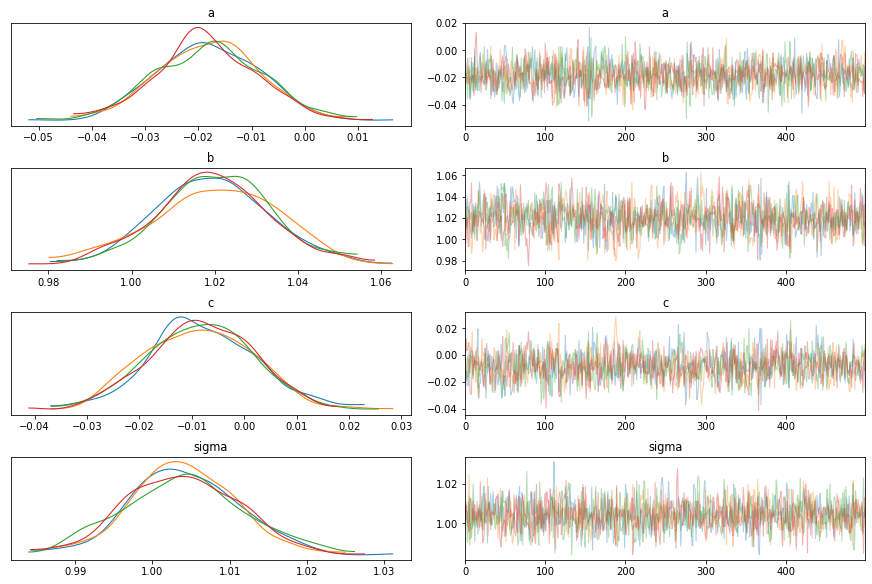

In [9]:
varnames = ['~mu']
az.plot_trace(full_trace, var_names=varnames)

In [10]:
az.summary(full_trace, varnames, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,-0.02,0.01,-0.04,-0.00
b,1.02,0.01,0.99,1.05
c,-0.01,0.01,-0.03,0.01
sigma,1.00,0.01,0.99,1.02


By using a mutiple regression we can spot that `x_spur`, is a spurious association to the variable `y` as its coeficient `c` is close to `0` with probability of both sides of `0` which means it does not explain the model.
<br>
<br>
It's interesting to notice that the value of `a` is also close to `0`, this is because the data is standardised (mean=0, std=1). 
<br>
<br>
We can represent the causal relationship with the following DAG(Directed Acyclic Graph):

### Conclusion*: 
<br>
Once we know `x_real` there's little or no additional predictive power in also knowing `x_spur`. However, if you don't have access to `x_real` then you'd definitely find value in knowing `x_spur`.

\* freely adapted from the book

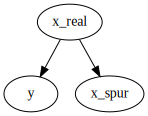

In [11]:
assoc = CausalGraphicalModel(
    nodes=["x_real", "x_spur", "y"], edges=[("x_real", "x_spur"), ("x_real", "y")]
)

assoc.draw()

In [12]:
%load_ext watermark
%watermark -iv -v -nuw

seaborn 0.10.1
pandas  1.1.1
pymc3   3.8
arviz   0.10.0
last updated: Sat Oct 31 2020 

CPython 3.7.7
IPython 7.17.0
watermark 2.0.2
